In [101]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.models import TiDEModel
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas_ta as ta

In [102]:
# Load and preprocess data for multiple stocks
file_paths = ["wavelet_reconstructed/Chunghwa_wavelet_reconstructed_only.csv",
              "wavelet_reconstructed/FET_wavelet_reconstructed_only.csv",
              "wavelet_reconstructed/Syscom_wavelet_reconstructed_only.csv"]

stock_names = ["Chunghua", "FET", "Syscom"]

In [103]:
stock_data = []

for file_path in file_paths:
    data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")
    data.columns = ["Adj Close", "Close", "High", "Low", "Open", "Volume"]

    # Feature engineering
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['RSI'] = ta.rsi(data['Close'], length=14)
    data['Volume_MA_5'] = data['Volume'].rolling(window=5).mean()
    data['Price_Range'] = data['High'] - data['Low']
    data['Daily_Return'] = ((data['Close'] - data['Open']) / data['Open']) * 100
    data['Volume_Change'] = data['Volume'].pct_change() * 100

    # Retain numerical columns and fill missing values
    data = data.select_dtypes(include=[np.number]).fillna(method='ffill').fillna(method='bfill').astype(np.float32)

    stock_data.append(data)

# Align data by date using a shared business day index
aligned_index = pd.date_range(start=min(data.index.min() for data in stock_data),
                              end=max(data.index.max() for data in stock_data), freq='B')

aligned_data = pd.concat([data.reindex(aligned_index).fillna(method='ffill').fillna(method='bfill') for data in stock_data],
                         axis=1, keys=[f"{stock_names[i]}" for i in range(len(stock_data))])

# Flatten multi-index columns for simplicity
aligned_data.columns = ['_'.join(col) for col in aligned_data.columns]

# Define features and target (for all stocks)
features = [col for col in aligned_data.columns if not col.endswith('_Close')]
targets = [col for col in aligned_data.columns if col.endswith('_Close')]

# Scale data
scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(aligned_data), columns=aligned_data.columns, index=aligned_data.index)

# Convert data to TimeSeries (multi-variate)
multi_series = TimeSeries.from_dataframe(scaled_data, freq='B')

/var/folders/13/x5r9hr1n1mz6hqhyldmf_7600000gn/T/ipykernel_41187/3568971605.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.select_dtypes(include=[np.number]).fillna(method='ffill').fillna(method='bfill').astype(np.float32)
/var/folders/13/x5r9hr1n1mz6hqhyldmf_7600000gn/T/ipykernel_41187/3568971605.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.select_dtypes(include=[np.number]).fillna(method='ffill').fillna(method='bfill').astype(np.float32)
/var/folders/13/x5r9hr1n1mz6hqhyldmf_7600000gn/T/ipykernel_41187/3568971605.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.select_dtypes(include=[np.number]).fillna(method='ffill').fillna(method='bfill').astype(np.float32)
/

In [104]:
# Split data into training, validation, and test sets
train_size = int(len(multi_series) * 0.9)
train_series = multi_series[:train_size]
test_series = multi_series[train_size:]

In [105]:
# TiDE model setup and training
model = TiDEModel(input_chunk_length=30, output_chunk_length=5, n_epochs=100)
model.fit(train_series)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 316 K  | train
6 | decoders         | Sequential       | 37.2 K | train
7 | temporal_decoder | _ResidualBlock   | 2.5 K  | train
8 | lookback_skip    | Linear           | 155    | train
--------------------------------------------------------------
356 K     Trainable params
0         Non-trainable params
356 K     Total params
1.424     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval 

Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 95.42it/s, train_loss=0.0038]  

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|██████████| 7/7 [00:00<00:00, 94.76it/s, train_loss=0.0038]


TiDEModel(output_chunk_shift=0, num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_hidden_size_past=None, temporal_hidden_size_future=None, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, input_chunk_length=30, output_chunk_length=5, n_epochs=100)

In [106]:
# Define separate scalers for each target
target_scalers = {target: MinMaxScaler() for target in targets}

# Scale individual targets
for target in targets:
    scaled_data[target] = target_scalers[target].fit_transform(aligned_data[[target]])

# Test predictions
y_test_pred_scaled = model.predict(n=len(test_series))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 110.17it/s]


In [107]:
# Calculate test MSE for each stock (directly on scaled data)
test_mse_scaled = {}
for i, target in enumerate(targets):
    # Extract the scaled actual and predicted values
    actual_values_scaled = test_series.univariate_component(i).values()
    predicted_values_scaled = y_test_pred_scaled.univariate_component(i).values()
    
    # Calculate MSE on scaled values
    mse_scaled = mean_squared_error(actual_values_scaled, predicted_values_scaled)
    test_mse_scaled[target] = mse_scaled

print("Test MSE (on scaled data) for each stock:")
for stock, mse_scaled in test_mse_scaled.items():
    print(f"{stock}: {mse_scaled:.4f}")

Test MSE (on scaled data) for each stock:
Chunghua_Close: 0.0108
FET_Close: 0.0115
Syscom_Close: 0.0148


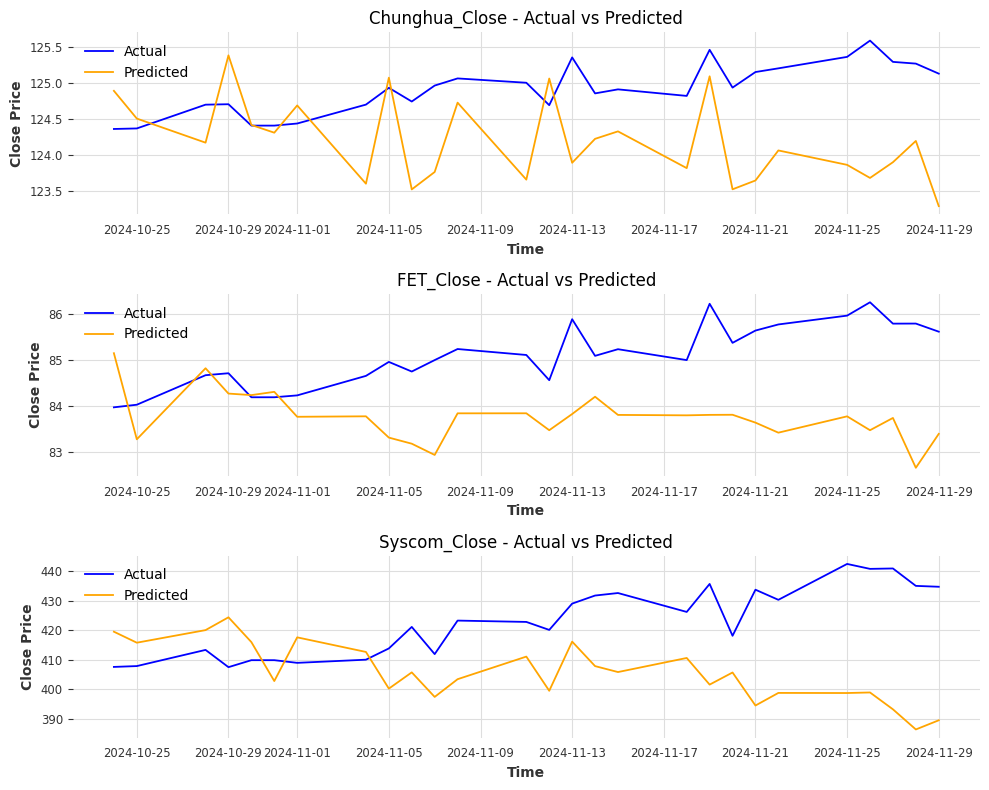

In [108]:
# Plot test predictions and actual values for each stock
plt.figure(figsize=(10, 8))

for i, target in enumerate(targets):
    # Inverse transform the actual and predicted values for the current stock
    actual_values = target_scalers[target].inverse_transform(test_series.univariate_component(i).values())
    predicted_values = target_scalers[target].inverse_transform(y_test_pred_scaled.univariate_component(i).values())

    # Create a subplot for each stock
    plt.subplot(len(targets), 1, i + 1)
    plt.plot(test_series.time_index, actual_values, label="Actual", color="blue")
    plt.plot(test_series.time_index, predicted_values, label="Predicted", color="orange")
    plt.title(f"{target} - Actual vs Predicted")
    plt.xlabel("Time")
    plt.ylabel("Close Price")
    plt.legend()
    plt.tight_layout()

plt.show()

In [109]:
# Predict the next 5 days
future_predictions_scaled = model.predict(n=5)
future_predictions = {}

for i, target in enumerate(targets):
    # Use the correct scaler for the specific target
    future_predictions[target] = target_scalers[target].inverse_transform(
        future_predictions_scaled.univariate_component(i).values().reshape(-1, 1)
    ).flatten()

# Save predictions to CSV
future_dates = pd.date_range(start=aligned_data.index[-1] + pd.Timedelta(days=1), periods=5, freq='B')
future_df = pd.DataFrame(future_predictions, index=future_dates)

# Ensure DataFrame columns are meaningful stock names
future_df.columns = [f"Predicted_{col}" for col in targets]

future_df.to_csv("future_predictions_multi_stock.csv", index_label="Date")

# Print predictions
print("Predicted Close Prices for the Next 5 Days:")
print(future_df)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 179.72it/s]
Predicted Close Prices for the Next 5 Days:
            Predicted_Chunghua_Close  Predicted_FET_Close  \
2024-12-02                124.892097            85.145126   
2024-12-03                124.507233            83.269417   
2024-12-04                124.172882            84.817314   
2024-12-05                125.384369            84.265602   
2024-12-06                124.418503            84.232201   

            Predicted_Syscom_Close  
2024-12-02              419.490784  
2024-12-03              415.780396  
2024-12-04              420.026337  
2024-12-05              424.348877  
2024-12-06              415.980835  


In [110]:
# Debugging DataFrame
debug_df = pd.DataFrame({
    "Date": test_series.time_index,
    "Actual Close (Inverse)": target_scalers[targets[0]].inverse_transform(test_series.univariate_component(0).values()).flatten(),
    "Predicted Close": target_scalers[targets[0]].inverse_transform(y_test_pred_scaled.univariate_component(0).values()).flatten()
}).set_index("Date")

# Display last 30 rows of debug DataFrame
print(debug_df.tail(30))

            Actual Close (Inverse)  Predicted Close
Date                                               
2024-10-24              124.362793       124.892097
2024-10-25              124.370163       124.507233
2024-10-28              124.700058       124.172882
2024-10-29              124.706238       125.384369
2024-10-30              124.409538       124.418503
2024-10-31              124.409538       124.311180
2024-11-01              124.438637       124.689377
2024-11-04              124.700935       123.603485
2024-11-05              124.933968       125.074455
2024-11-06              124.743797       123.524017
2024-11-07              124.965271       123.765991
2024-11-08              125.064316       124.727989
2024-11-11              125.004272       123.659889
2024-11-12              124.693008       125.062813
2024-11-13              125.355888       123.893684
2024-11-14              124.856544       124.225937
2024-11-15              124.912453       124.329575
2024-11-18  